In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import numpy as np
import pandas as pd
from skimage import color
from torch.utils.data import Dataset,random_split,DataLoader
import torch
import torch.nn as nn
from functools import cached_property
from tqdm import tqdm
from pathlib import Path
from shutil import rmtree
import pickle as pkl
from collections import defaultdict
import math
from typing import Callable
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage
import random
import itertools
from sklearn.model_selection import KFold
import tifffile as tif

In [8]:
IN_PATH = "..\\..\\data\\datasets\\raw\\"
OUT_PATH = "checkpoints\\"

# Various paths
DATA_PATH = f"{IN_PATH}new_color_checkers.csv"
GRAYS_DATA = f"{IN_PATH}grays.csv"
MODEL_BASE_DIR = OUT_PATH+"models\\"

REPRO_SEED = 42
generator = torch.Generator().manual_seed(REPRO_SEED)
TEXT_SEPARATOR = "-"*80


In [10]:
dataset = pd.read_csv(DATA_PATH).dropna()
print(f"Dataset shape: {dataset.shape}")
dataset.head()

Dataset shape: (861, 15)


,image_id,pixel_num,y_rect,x_rect,y_raw,x_raw,DA_R,DA_G,DA_B,N1_R,N1_G,N1_B,N2_R,N2_G,N2_B
0,0,1,45,47,595,1766,46.0,49.0,45.0,196.0,207.0,111.0,103.0,170.0,92.0
1,0,1,20,37,570,1756,53.0,51.0,55.0,193.0,204.0,91.0,94.0,169.0,101.0
2,0,1,61,19,611,1738,49.0,50.0,54.0,190.0,203.0,102.0,99.0,169.0,122.0
3,0,1,5,3,555,1722,54.0,53.0,44.0,199.0,210.0,103.0,97.0,166.0,114.0
4,0,1,36,30,586,1749,43.0,45.0,50.0,189.0,204.0,93.0,97.0,170.0,124.0


In [5]:
grays_df = pd.read_csv(GRAYS_DATA).dropna().groupby(by=["image_id","pixel_num"]).nth([0,1,4]).reset_index()#.mean().reset_index()
def increment_grays_pixel_nums(gdf,df_max_pixel_num):
    gdf["pixel_num"] = gdf.pixel_num.apply(lambda n: n+df_max_pixel_num)
    return gdf
grays_df = increment_grays_pixel_nums(grays_df,dataset.pixel_num.max())

In [6]:
full_dataset = pd.concat([dataset,grays_df]).sort_values(by=["image_id","pixel_num"])

In [7]:
def get_per_pixel_data(dataset,mean:True):
    if mean:
        per_pixel = dataset.groupby(by=["image_id","pixel_num"]).mean()[["DA_R", "DA_G", "DA_B","N1_R","N1_G","N1_B","N2_R","N2_G","N2_B"]]
    else:
        per_pixel = dataset[["DA_R", "DA_G", "DA_B","N1_R","N1_G","N1_B","N2_R","N2_G","N2_B"]].copy()
    per_pixel['DA_RGB'] = list(zip(per_pixel.DA_R, per_pixel.DA_G, per_pixel.DA_B))
    per_pixel['N1_RGB'] = list(zip(per_pixel.N1_R, per_pixel.N1_G, per_pixel.N1_B))
    per_pixel['N2_RGB'] = list(zip(per_pixel.N2_R, per_pixel.N2_G, per_pixel.N2_B))
    per_pixel = per_pixel.drop(columns=['DA_R', 'DA_G', 'DA_B', 
                                        'N1_R', 'N1_G', 'N1_B',
                                        'N2_R', 'N2_G', 'N2_B'])
    for col in per_pixel.columns:
        per_pixel[col] = per_pixel[col].apply(lambda rgb: np.array(rgb)/255)
    return per_pixel
per_pixel = get_per_pixel_data(full_dataset,mean=False)
per_pixel.head()

,DA_RGB,N1_RGB,N2_RGB
0,"[0.1803921568627451, 0.19215686274509805, 0.17...","[0.7686274509803922, 0.8117647058823529, 0.435...","[0.403921568627451, 0.6666666666666666, 0.3607..."
1,"[0.20784313725490197, 0.2, 0.21568627450980393]","[0.7568627450980392, 0.8, 0.3568627450980392]","[0.3686274509803922, 0.6627450980392157, 0.396..."
2,"[0.19215686274509805, 0.19607843137254902, 0.2...","[0.7450980392156863, 0.796078431372549, 0.4]","[0.38823529411764707, 0.6627450980392157, 0.47..."
3,"[0.21176470588235294, 0.20784313725490197, 0.1...","[0.7803921568627451, 0.8235294117647058, 0.403...","[0.3803921568627451, 0.6509803921568628, 0.447..."
4,"[0.16862745098039217, 0.17647058823529413, 0.1...","[0.7411764705882353, 0.8, 0.36470588235294116]","[0.3803921568627451, 0.6666666666666666, 0.486..."


In [8]:
src_col_mapping = {"DA":"DA_RGB","N1":"N1_RGB","N2":"N2_RGB"}
for col in src_col_mapping.values():
    per_pixel[col.replace("_RGB","_LAB")] = per_pixel[col].apply(color.rgb2lab)
per_pixel.head()


,DA_RGB,N1_RGB,N2_RGB,DA_LAB,N1_LAB,N2_LAB
0,"[0.1803921568627451, 0.19215686274509805, 0.17...","[0.7686274509803922, 0.8117647058823529, 0.435...","[0.403921568627451, 0.6666666666666666, 0.3607...","[19.910921946004898, -2.253991584688836, 2.102...","[80.46561545924969, -17.77315789246725, 46.166...","[63.67600086091046, -36.90599170594627, 33.569..."
1,"[0.20784313725490197, 0.2, 0.21568627450980393]","[0.7568627450980392, 0.8, 0.3568627450980392]","[0.3686274509803922, 0.6627450980392157, 0.396...","[21.580876008163187, 1.8089169317506981, -2.20...","[79.20202706525262, -19.29126123122088, 54.032...","[63.08917398882903, -37.90359207488259, 28.012..."
2,"[0.19215686274509805, 0.19607843137254902, 0.2...","[0.7450980392156863, 0.796078431372549, 0.4]","[0.38823529411764707, 0.6627450980392157, 0.47...","[20.82958426835004, 0.5361257642293726, -2.679...","[78.82140736958203, -19.044172167970775, 48.41...","[63.698675550109726, -32.65350093515407, 17.50..."
3,"[0.21176470588235294, 0.20784313725490197, 0.1...","[0.7803921568627451, 0.8235294117647058, 0.403...","[0.3803921568627451, 0.6509803921568628, 0.447...","[21.98900542420381, -1.47527127068095, 5.84625...","[81.40997694125959, -18.819619267697817, 51.17...","[62.53086685938197, -33.363422040380506, 20.27..."
4,"[0.16862745098039217, 0.17647058823529413, 0.1...","[0.7411764705882353, 0.8, 0.36470588235294116]","[0.3803921568627451, 0.6666666666666666, 0.486...","[18.455564277887163, 0.38416442645333726, -3.5...","[78.92345463262656, -20.742131622777272, 52.72...","[63.953647907407614, -33.31730407488187, 16.74..."


In [9]:
class Metric():
    def __init__(self,name:str,fn,better_direction : str):
        self.name:str = name
        self.fn=fn
        assert better_direction in ["lower","higher"]
        self.better_direction = better_direction

    def __call__(self, *args, **kwds):
        return self.fn(*args,**kwds)
    
def rmse(gt,preds):
    gt = np.array(gt)
    preds = np.array(preds)
    return np.sqrt(np.sum((preds-gt)**2))

ALL_METRICS = [
    Metric("RMSE",rmse,"lower")
]

In [10]:
class Config():
    def __init__(self,config_or_dict,name:str="",name_features:list|None=None,update_dict:dict|None=None):
        self.name = name
        if name_features is None:
            name_features = ['epochs']
        elif 'epochs' not in name_features:
            name_features = ['epochs'] + name_features
        self.name_features = name_features
        if config_or_dict is None:
            config_or_dict = Config.get_default_train_config()
        if isinstance(config_or_dict,Config):
            config_dict = config_or_dict.config_dict
        else:
            config_dict = config_or_dict
        if update_dict is not None:
            config_dict.update(update_dict)
        assert 'epochs' in config_dict
        self.config_dict = config_dict
    
    def __getitem__(self, key):
        return self.config_dict[key]
    
    def __contains__(self,key):
        return key in self.config_dict
    
    @staticmethod
    def get_default_train_config():
        return Config({
            'tt_split': 0.75, # Train-test split
            'bs': 8, # Training batch size
            'base_lr': 1*(10**-1), # Starting learning rate,
            'end_lr': 1*(10**-3), # Smallest lr you will converge to
            'epochs': 50, # epochs
            'warmup_epochs': 2 # number of warmup epochs
            }) 

    @cached_property
    def ident(self) -> str:
        return ('_'.join([self.name]+[str(self.config_dict[feature]) for feature in self.name_features])).lower()
    
    def update(self,other,name_merge="keep_base"):
        assert isinstance(other,Config) or isinstance(other,dict)
        assert name_merge in ["keep_base","keep_new","concat"]
        return Config(self.config_dict.update(other.config_dict if isinstance(other,Config) else other),self.name if name_merge == "keep_merge" or isinstance(other,dict) else (other.name if name_merge == "keep_new" else other.name+'_'+self.name))


In [11]:
def validate_model(model,eval_dataloader,device,metrics: list|None=None, print_validation=True):
    model.eval()
    if metrics is None:
        metrics = ALL_METRICS
    gt = []
    preds = []
    with torch.no_grad():
        for batch in (tqdm(eval_dataloader,desc="Evaluating model",total=len(eval_dataloader)) if print_validation else eval_dataloader):
            x,gt = batch['x'].to(device),batch['y'].detach().cpu().numpy().tolist()
            preds = model(x).detach().cpu().numpy().tolist()
    all_res = [metric(gt,preds) for metric in metrics]
    return all_res

def maybe_update_result(current_value,new_result,better="lower"):
    assert better in ["lower","higher"]
    updated = False
    new_value = current_value
    if current_value == -np.inf or (better == "lower" and new_result < current_value) or (better == "higher" and new_result > current_value):
        updated = True
        new_value = new_result
    return updated,new_value
                
def get_scheduler(config, optimizer, train_len):
    epochs = config['epochs']
    warmup_epochs = config['warmup_epochs']
    base_lr = config['base_lr']
    end_lr = config['end_lr']
    scheduler_type = config['scheduler_type']
    if scheduler_type == 'multistep':
        # We do the following technique : high LR in the beginning, low towards the end
        # starting from base_lr we decrease up to e-5, by a factor of 1/sqrt(10) ~0.3162  k times
        fct = 1/np.sqrt(10)
        end_epoch = min(32, epochs)
        num_groups = math.ceil(math.log(end_lr / base_lr, fct))
        group_size = max(1, end_epoch // num_groups)
        milestones = [warmup_epochs + group_size * i for i in range(1, num_groups)]
        return torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, fct)
    elif scheduler_type == 'cosine':
        return torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, 
            T_max=epochs - warmup_epochs, 
            eta_min=end_lr
        ) 
    elif scheduler_type == 'exponential':
        gamma = (end_lr / base_lr) ** (1 / (epochs - warmup_epochs))
        return torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    elif scheduler_type == 'reduce_on_plateau':
        return torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=8,
            min_lr=end_lr,
        )
    elif scheduler_type == 'one_cycle':
        return torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=base_lr * 10,
            total_steps=epochs * train_len,
            pct_start=0.3,
            final_div_factor=base_lr / end_lr
        )
    else:
        raise ValueError(f"Unknown scheduler type: {scheduler_type}")

In [12]:
def train_predictor(config:Config,df,model_fn:Callable[[Config],nn.Module],
                    dataloader_fn:Callable[[Config,pd.DataFrame,torch.Generator],tuple[DataLoader,DataLoader,Dataset]],
                    override_previous_dir=False,print_validation = True,tqdm_train=True, generator=None) -> tuple[nn.Module,Path,dict,list]:
    # Trains a model
    # When `override_previous_dir` = True, destroy the directory of the previous saved run with the same config id (if it exists)
    device = "cpu" if not torch.cuda.is_available() else "cuda"
    print("Using device:", device)
    if (device == 'cuda'):
        print(f"Device name: {torch.cuda.get_device_name(device.index)}")
        print(f"Device memory: {torch.cuda.get_device_properties(device.index).total_memory / 1024 ** 3} GB")
    device = torch.device(device)
    if generator is None:
        generator = torch.Generator()
        generator.manual_seed(REPRO_SEED)
    train_dataloader, eval_dataloader, test_dataset = dataloader_fn(config,df,generator)
    epochs = config["epochs"]
    model = model_fn(config).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['base_lr'], eps=1e-6,amsgrad=True)
    loss_fn = torch.nn.MSELoss(reduction="sum") # Minimizing the MSE loss corresponds to minimizing Delta E LAB      

    # LR scheduler
    lr_scheduler = get_scheduler(config, optimizer, len(train_dataloader))
    metrics_to_use = ALL_METRICS
    best_results = {metric:-np.inf for metric in metrics_to_use}
    model_bases = Path(MODEL_BASE_DIR)
    model_bases.mkdir(parents=True,exist_ok=True)
    save_dir = model_bases / config.ident
    if override_previous_dir and save_dir.exists():
        assert save_dir.is_dir(),f"{save_dir.absolute().as_posix()} exists and is not a directory!"
        rmtree(save_dir.absolute().as_posix())
    save_dir.mkdir(parents = False,exist_ok=False)
    for metric in metrics_to_use:
        (save_dir/metric.name).mkdir(parents = False,exist_ok=False)

    all_losses = []
    all_results = defaultdict(list)
    worse_rmse_count = 0

    for epoch in range(epochs):
        torch.cuda.empty_cache()
        model.train()
        current_lr = optimizer.param_groups[0]['lr'] if isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau) else lr_scheduler.get_last_lr()[0]
        train_iterator = tqdm(train_dataloader, desc=f"Processing epoch {epoch:02d} w/ lr ({current_lr:.6f})", total=len(train_dataloader)) if tqdm_train else train_dataloader
        c = 0
        gl = 0

        # Train
        for batch in train_iterator:
            x,y = batch['x'].to(device),batch['y'].to(device)
            prediction = model(x)
            loss = loss_fn(prediction,y)
            c+=1
            cl = loss.item()
            gl += cl
            all_losses.append(cl)
            if tqdm_train:
                train_iterator.set_postfix({"loss": f"{gl/c:6.3f}"})
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        
        # Validate
        print_val = print_validation and (epoch % 20 == 0)
        if print_val:
            print(TEXT_SEPARATOR)
        all_current_results = validate_model(model,eval_dataloader,device,metrics_to_use,print_validation=print_val)
        
        primary_metric_idx = next((i for i, m in enumerate(metrics_to_use) if m.name.lower() == "rmse"), 0)
        primary_metric_result = all_current_results[primary_metric_idx]
        
        
        for metric,new_metric_result in zip(metrics_to_use,all_current_results):    
            if print_val:
                print(f"{metric.name}: {new_metric_result}\n")
            all_results[metric].append(new_metric_result)
            # Save best models
            curr_metric_res = best_results[metric]
            updated,new_res = maybe_update_result(curr_metric_res,new_metric_result,metric.better_direction)
            best_results[metric] = new_res
            if updated:
                if metric.name.lower() == "rmse": 
                    worse_rmse_count = 0
                # Save the model
                metric_dir:Path = save_dir/metric.name
                fname:Path = metric_dir/"model.pt"
                if fname.exists():
                    assert fname.is_file()
                    fname.unlink()
                torch.save(model.state_dict(),fname.absolute().as_posix())
                with open((metric_dir/"config.pkl").absolute().as_posix(),"wb") as f:
                    pkl.dump(config,f,pkl.HIGHEST_PROTOCOL)
                # save the loss!
                with open((metric_dir/"loss.txt").absolute().as_posix(),"w") as f:
                    f.write(f"Loss = {new_res:.5f}")
            elif metric.name.lower() == "rmse": 
                worse_rmse_count += 1
        if print_val:
            print(TEXT_SEPARATOR)
        
        # Update LR
        if isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            lr_scheduler.step(primary_metric_result)
        else:
            lr_scheduler.step()

        if worse_rmse_count >=3:
            if print_val:
                print(f"Reached worse RMSE on validation set three epochs in a row, early stopping the training to avoid overfitting!")
            # break
        
    return model,save_dir, all_results, all_losses, test_dataset

In [13]:
class ColorCheckerLabDataset(Dataset):
    def __init__(self, lab_df:pd.DataFrame,keep_one_source = False):
        assert all(col_name in lab_df.columns for col_name in ["DA_LAB","N1_LAB","N2_LAB"])
        n1 = np.array(lab_df["N1_LAB"].tolist())
        n2 = np.array(lab_df["N2_LAB"].tolist())
        da = np.array(lab_df["DA_LAB"].tolist())
        assert n1.shape == n2.shape == da.shape
        assert len(n1.shape) == 2, f"n1.shape: {n1.shape}, n1[0]: {n1[0]}, {type(n1)}, {type(n1[0])}"
        assert n1.shape[1] == 3
        if not keep_one_source:
            self.x = np.hstack([n1,n2]).reshape(-1,3)
            self.y = np.hstack([da,da]).reshape(-1,3)
        else:
            self.x = n1
            self.y = da

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return {'x':torch.Tensor(self.x[idx]),
                'y':torch.Tensor(self.y[idx])}

def get_lab_dataloaders(config:Config,df:pd.DataFrame,generator:torch.Generator|None=None) -> tuple[DataLoader,DataLoader,Dataset]:
    tt_split = config["tt_split"]
    if isinstance(tt_split,float):
        tt_split = [tt_split,1-tt_split]
    assert isinstance(tt_split,list), f"{type(tt_split)} {tt_split}"
    assert len(tt_split) == 2
    assert sum(tt_split) == 1
    if generator is None:
        generator = torch.Generator()
        generator.manual_seed(REPRO_SEED)
    dataset = ColorCheckerLabDataset(df[["DA_LAB","N1_LAB","N2_LAB"]],keep_one_source=config["keep_one_source"])
    train_dataset, test_dataset = random_split(dataset, tt_split, generator=generator)
    bs = config["bs"]
    train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True, generator=generator)
    test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=False)
    return train_dataloader, test_dataloader, test_dataset


In [38]:
class OneHiddenLayerNN(nn.Module):
    def __init__(self,config:Config):
        super().__init__()

        self.seq = nn.Sequential(
            nn.Linear(3,config['hidden_size']),
            nn.Tanh(),
            nn.Linear(config['hidden_size'],3)
        )
        self.linear = nn.Linear(3,3)

    def forward(self,x):
        seq = self.seq(x)
        lin = self.linear(x)
        return lin + seq

class CombHiddenLayerNN(nn.Module):
    def __init__(self,config:Config):
        super().__init__()

        self.seq = nn.Sequential(
            nn.Linear(3,config['hidden_size']),
            nn.Tanh(),
            nn.Linear(config['hidden_size'],3)
        )
        self.linear = nn.Linear(3,3)
        self.comb = nn.Linear(6,3)

    def forward(self,x):
        seq = self.seq(x)
        lin = self.linear(x)
        stacked = torch.hstack([lin,seq])#.reshape(-1,6)
        return self.comb(stacked)


class EnhCombHiddenLayerNN(nn.Module):
    def __init__(self,config:Config):
        super().__init__()

        self.lab_seq = nn.Sequential(
            nn.Linear(3,config['hidden_size']),
            nn.Tanh(),
            nn.Linear(config['hidden_size'],3)
        )
        self.lab_linear = nn.Linear(3,3)
        self.lab_comb = nn.Linear(6,3)

        self.log_dens_linear = nn.Linear(3,3)
        self.final_comb = nn.Linear(6,3)

    def forward(self,x):
        seq = self.lab_seq(x)
        lin = self.lab_linear(x)
        stacked = torch.hstack([lin,seq])#.reshape(-1,6)
        final_lab = self.lab_comb(stacked)

        x_rgb = self.lab2rgb(x)
        log_density = -torch.log10(x_rgb)
        model_processed = self.log_dens_linear(log_density)
        back_to_lab = self.rgb2lab(torch.pow(10,model_processed))
        return self.final_comb(torch.hstack([final_lab,back_to_lab]))
    
    @staticmethod
    def lab2rgb(lab):
        L, a, b = torch.split(lab, 1, dim=-1)
        
        # LAB to XYZ
        y = (L + 16.0) / 116.0
        x = a / 500.0 + y
        z = y - b / 200.0
        
        xyz_condition = torch.tensor(0.008856, device=lab.device, dtype=lab.dtype)
        
        x_cube = x ** 3
        x_linear = (x - 16.0/116.0) / 7.787
        x = torch.where(x_cube > xyz_condition, x_cube, x_linear) * 0.95047
        
        y_cube = y ** 3
        y_linear = (y - 16.0/116.0) / 7.787
        y = torch.where(y_cube > xyz_condition, y_cube, y_linear)
        
        z_cube = z ** 3
        z_linear = (z - 16.0/116.0) / 7.787
        z = torch.where(z_cube > xyz_condition, z_cube, z_linear) * 1.08883
        
        xyz = torch.cat([x, y, z], dim=-1)
        rgb_from_xyz = torch.tensor([
            [3.2406, -1.5372, -0.4986],
            [-0.9689, 1.8758, 0.0415],
            [0.0557, -0.2040, 1.0570]
        ], device=lab.device, dtype=lab.dtype)
        
        orig_shape = xyz.shape[:-1]
        xyz_reshaped = xyz.reshape(-1, 3)
        
        rgb = torch.matmul(xyz_reshaped, rgb_from_xyz.T)
        rgb = rgb.reshape(*orig_shape, 3)
        
        r, g, b = torch.split(rgb, 1, dim=-1)
        rgb_condition = torch.tensor(0.0031308, device=lab.device, dtype=lab.dtype)
        
        r_gamma = 1.055 * (r ** (1.0/2.4)) - 0.055
        r_linear = 12.92 * r
        r = torch.where(r > rgb_condition, r_gamma, r_linear)
        
        g_gamma = 1.055 * (g ** (1.0/2.4)) - 0.055
        g_linear = 12.92 * g
        g = torch.where(g > rgb_condition, g_gamma, g_linear)
        
        b_gamma = 1.055 * (b ** (1.0/2.4)) - 0.055
        b_linear = 12.92 * b
        b = torch.where(b > rgb_condition, b_gamma, b_linear)
        
        r = torch.clamp(r, 0.0, 1.0) * 255.0
        g = torch.clamp(g, 0.0, 1.0) * 255.0
        b = torch.clamp(b, 0.0, 1.0) * 255.0
        
        rgb = torch.cat([r, g, b], dim=-1)
        return rgb


    @staticmethod
    def rgb2lab(rgb):
        r, g, b = torch.split(rgb / 255.0, 1, dim=-1)
        rgb_condition = torch.tensor(0.04045, device=rgb.device, dtype=rgb.dtype)
        
        r_gamma = ((r + 0.055) / 1.055) ** 2.4
        r_linear = r / 12.92
        r = torch.where(r > rgb_condition, r_gamma, r_linear)
        
        g_gamma = ((g + 0.055) / 1.055) ** 2.4
        g_linear = g / 12.92
        g = torch.where(g > rgb_condition, g_gamma, g_linear)
        
        b_gamma = ((b + 0.055) / 1.055) ** 2.4
        b_linear = b / 12.92
        b = torch.where(b > rgb_condition, b_gamma, b_linear)
        
        rgb = torch.cat([r, g, b], dim=-1)
        xyz_from_rgb = torch.tensor([
            [0.4124, 0.3576, 0.1805],
            [0.2126, 0.7152, 0.0722],
            [0.0193, 0.1192, 0.9505]
        ], device=rgb.device, dtype=rgb.dtype)
        
        orig_shape = rgb.shape[:-1]
        rgb_reshaped = rgb.reshape(-1, 3)
        
        xyz = torch.matmul(rgb_reshaped, xyz_from_rgb.T)
        xyz = xyz.reshape(*orig_shape, 3)
        
        x, y, z = torch.split(xyz, 1, dim=-1)
        x = x / 0.95047
        y = y / 1.00000
        z = z / 1.08883
        
        xyz_condition = torch.tensor(0.008856, device=rgb.device, dtype=rgb.dtype)
        
        x_cbrt = x ** (1.0/3.0)
        x_linear = (7.787 * x) + 16.0/116.0
        x = torch.where(x > xyz_condition, x_cbrt, x_linear)
        
        y_cbrt = y ** (1.0/3.0)
        y_linear = (7.787 * y) + 16.0/116.0
        y = torch.where(y > xyz_condition, y_cbrt, y_linear)
        
        z_cbrt = z ** (1.0/3.0)
        z_linear = (7.787 * z) + 16.0/116.0
        z = torch.where(z > xyz_condition, z_cbrt, z_linear)
        
        L = (116.0 * y) - 16.0
        a = 500.0 * (x - y)
        b = 200.0 * (y - z)
        
        lab = torch.cat([L, a, b], dim=-1)
        return lab


def get_linear_model(config:Config):
    return OneHiddenLayerNN(config)

def get_linear_model_config():
    return Config({
            'tt_split': 0.8, # Train-test split
            'bs': 1, # Training batch size --> 1 = GD (not SGD)
            'base_lr': 1*(10**-1), # Starting learning rate,
            'end_lr': 1*(10**-4), # Smallest lr you will converge to
            'epochs': 100, # epochs
            'warmup_epochs': 2, # number of warmup epochs
            'hidden_size': 15,
            "keep_one_source": True,
            "scheduler_type": "reduce_on_plateau",
            "keep_one_source":True,
            },name="gr3_tanh_hidden",name_features=["hidden_size","keep_one_source","scheduler_type"])


def get_comb_model(config:Config):
    return CombHiddenLayerNN(config)

def get_comb_model_config():
    return Config({
            'tt_split': 0.8, # Train-test split
            'bs': 1, # Training batch size --> 1 = GD (not SGD)
            'base_lr': 1*(10**-1), # Starting learning rate,
            'end_lr': 1*(10**-4), # Smallest lr you will converge to
            'epochs': 100, # epochs
            'warmup_epochs': 2, # number of warmup epochs
            'hidden_size': 10,
            "keep_one_source": True,
            "scheduler_type": "reduce_on_plateau",
            "keep_one_source":True,
            },name="enhcombgr3_tanh_hidden",name_features=["hidden_size","keep_one_source","scheduler_type"])

In [21]:
model, save_dir, all_results, all_losses, test_dataset = train_predictor(get_comb_model_config(),per_pixel,get_comb_model,get_lab_dataloaders,override_previous_dir=True,print_validation=True,tqdm_train=True, generator=None)


Using device: cuda
Device name: NVIDIA GeForce RTX 2060
Device memory: 5.99969482421875 GB


Processing epoch 00 w/ lr (0.100000): 100%|██████████| 794/794 [00:06<00:00, 124.03it/s, loss=1567.647]


--------------------------------------------------------------------------------


Evaluating model: 100%|██████████| 198/198 [00:00<00:00, 290.78it/s]


RMSE: 25.987654804036435

--------------------------------------------------------------------------------


Processing epoch 20 w/ lr (0.050000): 100%|██████████| 794/794 [00:06<00:00, 127.33it/s, loss=675.925]


--------------------------------------------------------------------------------


Evaluating model: 100%|██████████| 198/198 [00:00<00:00, 270.60it/s]


RMSE: 23.017516144899506

--------------------------------------------------------------------------------
Reached worse RMSE on validation set three epochs in a row, early stopping the training to avoid overfitting!


Processing epoch 40 w/ lr (0.006250): 100%|██████████| 794/794 [00:07<00:00, 111.30it/s, loss=508.431]


--------------------------------------------------------------------------------


Evaluating model: 100%|██████████| 198/198 [00:00<00:00, 243.82it/s]


RMSE: 25.597902336545626

--------------------------------------------------------------------------------
Reached worse RMSE on validation set three epochs in a row, early stopping the training to avoid overfitting!


Processing epoch 60 w/ lr (0.001563): 100%|██████████| 794/794 [00:06<00:00, 132.22it/s, loss=492.786]


--------------------------------------------------------------------------------


Evaluating model: 100%|██████████| 198/198 [00:00<00:00, 281.62it/s]


RMSE: 20.733507203103443

--------------------------------------------------------------------------------
Reached worse RMSE on validation set three epochs in a row, early stopping the training to avoid overfitting!


Processing epoch 80 w/ lr (0.000391): 100%|██████████| 794/794 [00:06<00:00, 128.94it/s, loss=485.911]


--------------------------------------------------------------------------------


Evaluating model: 100%|██████████| 198/198 [00:00<00:00, 316.16it/s]


RMSE: 22.2488491215181

--------------------------------------------------------------------------------
Reached worse RMSE on validation set three epochs in a row, early stopping the training to avoid overfitting!


Processing epoch 99 w/ lr (0.000100): 100%|██████████| 794/794 [00:06<00:00, 126.37it/s, loss=484.707]


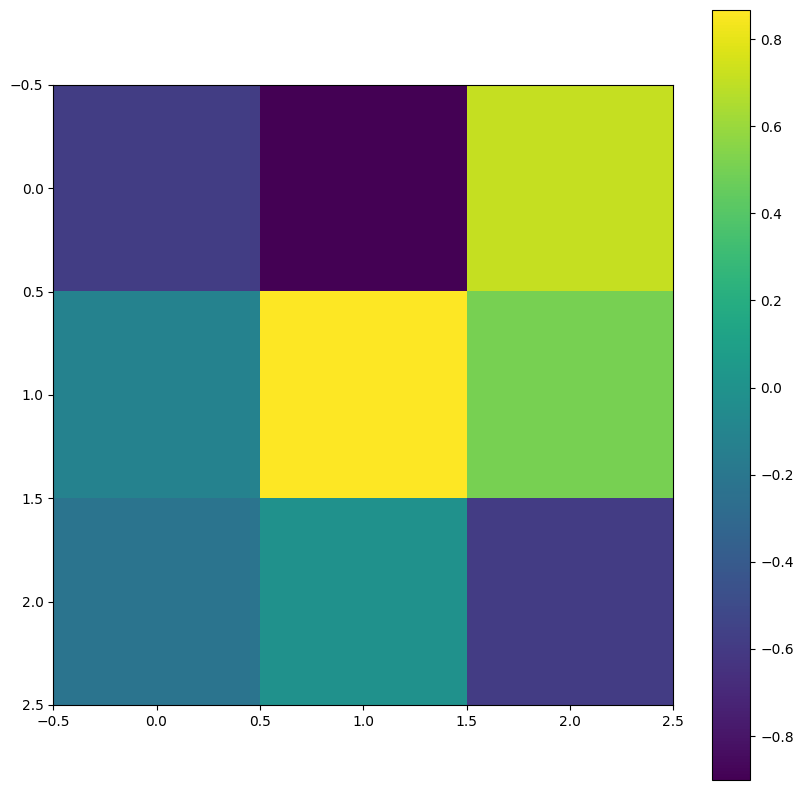

In [ ]:
def visualize_model_weights(model:OneHiddenLayerNN|CombHiddenLayerNN|EnhCombHiddenLayerNN):
    # The model is a shallow neural network with one hidden layer
    # It converts 3D LAB values from a negative image to expected 3D LAB values of the positive (taking care of the color filter)
    weights = (model.lab_linear if "comb" not in dir(model) else model.final_comb if "enh" in dir(model) else model.lab_comb).weight.data.cpu().numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(weights)
    plt.colorbar()
    plt.show()

visualize_model_weights(model)


In [25]:
def visualize_one_sample(gt, x, pred):
    fig, ax = plt.subplots(figsize=(8, 6))

    gt_rgb = skimage.color.lab2rgb(gt)
    x_rgb = skimage.color.lab2rgb(x) 
    pred_rgb = skimage.color.lab2rgb(pred)

    ax.set_xlim(0, 2)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    gt_square = patches.Rectangle((0, 0), 1, 1, linewidth=1, 
                                edgecolor='black', facecolor=gt_rgb)
    ax.add_patch(gt_square)
    
    x_rect = patches.Rectangle((1, 0.5), 1, 0.5, linewidth=1,
                             edgecolor='black', facecolor=x_rgb)
    ax.add_patch(x_rect)
    
    pred_rect = patches.Rectangle((1, 0), 1, 0.5, linewidth=1,
                                edgecolor='black', facecolor=pred_rgb)
    ax.add_patch(pred_rect)

    # Add labels
    ax.text(0.5, -0.1, "Ground Truth", ha='center')
    ax.text(1.5, 1.05, "Input", ha='center')
    ax.text(1.5, -0.1, "Prediction", ha='center')
    delta_e = np.sqrt(np.sum((pred - gt)**2))
    
    box_color = 'green' if delta_e < 2.3 else 'red'
    text = f'$\Delta E_{{ab}} = {delta_e:.2f}$'
    
    text_box = dict(boxstyle='round,pad=0.5', fc='white', 
                   ec=box_color, lw=2)
    ax.text(1, -0.2, text, ha='center', va='center',
            bbox=text_box)

def viz_sample(model,test_ds,idx):
    inp = test_ds[idx]
    model_device = next(model.parameters()).device
    x = inp["x"].to(model_device)
    gt = inp["y"].detach().cpu().numpy()
    model.eval()
    with torch.no_grad():
        pred = model(x).detach().cpu().numpy()
    x = x.detach().cpu().numpy()
    visualize_one_sample(gt,x,pred)


In [39]:
best_model_path = f"{OUT_PATH}\\models\\combgr3_tanh_hidden_100_10_true_reduce_on_plateau\\RMSE\\"
with open(best_model_path+"config.pkl","rb") as f:
    best_model_config = pkl.load(f)
best_model = EnhCombHiddenLayerNN(best_model_config) if "enh" in best_model_path else CombHiddenLayerNN(best_model_config) if "comb" in best_model_path else OneHiddenLayerNN(best_model_config)
best_model.load_state_dict(torch.load(best_model_path+"model.pt"))

<All keys matched successfully>

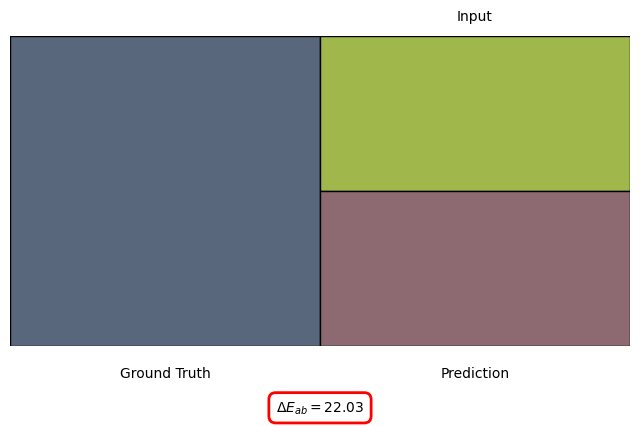

In [40]:

viz_sample(best_model,test_dataset,random.randint(0,len(test_dataset)))

In [ ]:
!cd

c:\Users\vesbr\Documents\EPFL\Master\MA4\Computational_Photography\positron\src\scripts\kp_calc\analysis


..\..\..\..\data\prepro\cropped\source1\DSCF7394.tif


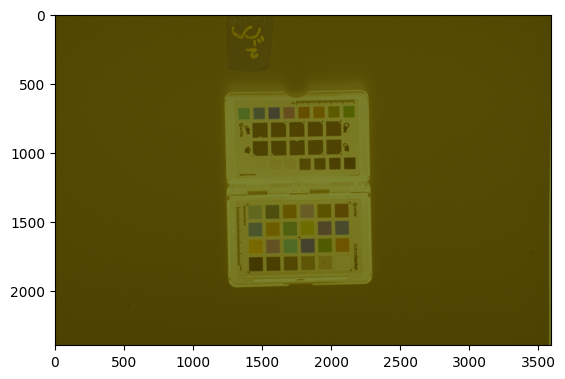

In [47]:
IMAGES_PATH = "..\\..\\..\\..\\data\\prepro\\cropped\\source1\\"
GT = "..\\..\\..\\..\\data\\prepro\\da_tiff\\DSCF7040.tif"
all_images = sorted(list(Path(IMAGES_PATH).glob("*.tif")))
test_img_path = all_images[-4]
print(test_img_path)
test_img = tif.imread(test_img_path)
plt.imshow(test_img)

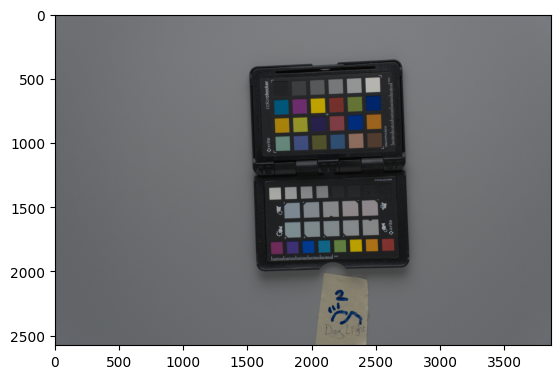

In [48]:
plt.imshow(tif.imread(GT))

[29.64848   -3.3702552 38.43682  ]
torch.Size([8608828, 3])
(8608828, 3)
(2396, 3593, 3)
[0.7773633  0.68758774 0.64410114]
tensor([73.2314,  6.4213,  8.7004])


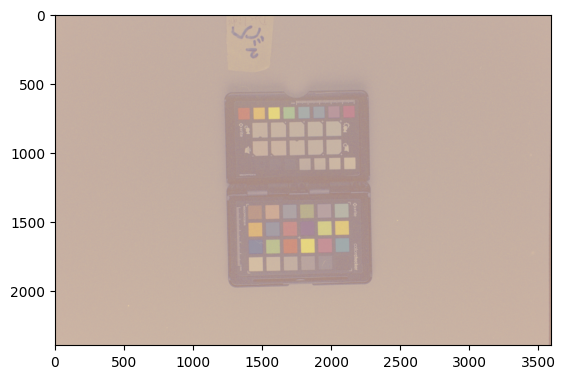

In [42]:
def transform_image(model,img_rgb:np.ndarray):
    model.eval()
    img = color.rgb2lab(img_rgb)
    frst_image = img[0,0,:] 
    print(frst_image)
    img = torch.from_numpy(img).float()
    base_shape = img.shape
    with torch.no_grad():
        model_device = next(model.parameters()).device
        img = img.reshape(-1,3).to(model_device)
        print(img.shape)
        pred = skimage.color.lab2rgb(model(img).detach().cpu().numpy())
        print(pred.shape)
        pred = pred.reshape(base_shape)
        print(pred.shape)
        print(pred[0,0,:])
        print(model(torch.from_numpy(frst_image).to(model_device)))
    return pred 
plt.imshow(transform_image(best_model,test_img))